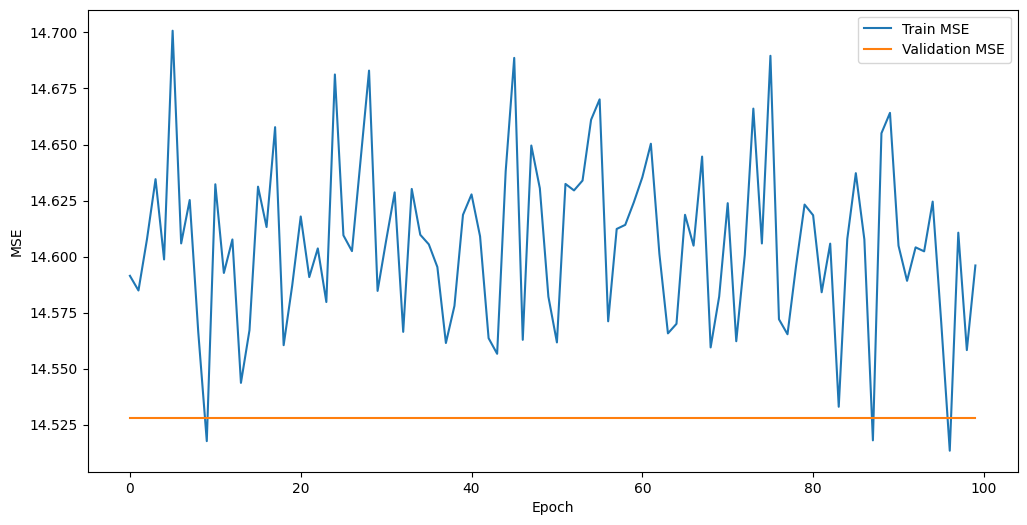

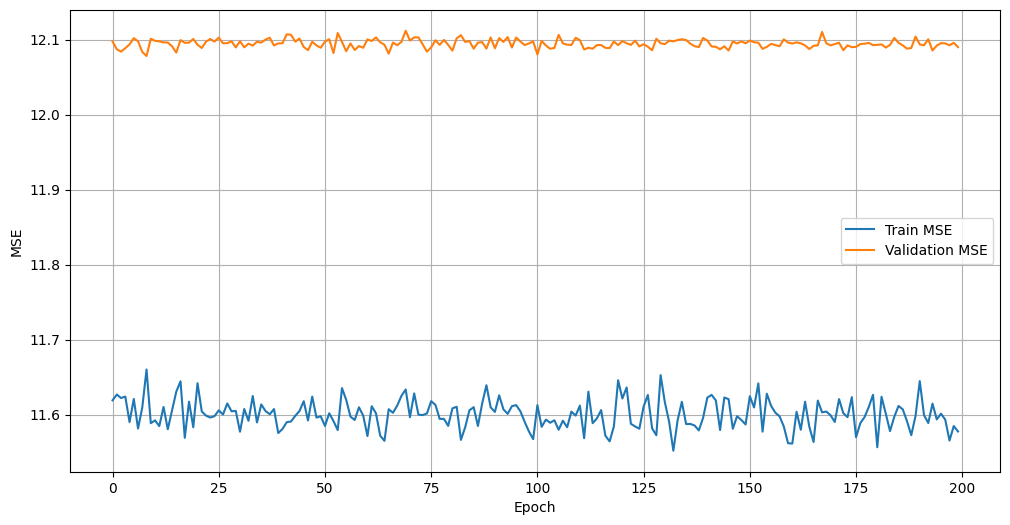

In [22]:
%run homework_modules.ipynb

In [4]:
import torch
from torch.autograd import Variable
import numpy
import unittest

In [ ]:
class TestLayers(unittest.TestCase):
    def test_Linear(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in, n_out = 2, 3, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Linear(n_in, n_out)
            custom_layer = Linear(n_in, n_out)
            custom_layer.W = torch_layer.weight.data.numpy()
            custom_layer.b = torch_layer.bias.data.numpy()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-10, 10, (batch_size, n_out)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

            # 3. check layer parameters grad
            custom_layer.accGradParameters(layer_input, next_layer_grad)
            weight_grad = custom_layer.gradW
            bias_grad = custom_layer.gradb
            torch_weight_grad = torch_layer.weight.grad.data.numpy()
            torch_bias_grad = torch_layer.bias.grad.data.numpy()
            self.assertTrue(np.allclose(torch_weight_grad, weight_grad, atol=1e-6))
            self.assertTrue(np.allclose(torch_bias_grad, bias_grad, atol=1e-6))

    def test_SoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Softmax(dim=1)
            custom_layer = SoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)
            next_layer_grad = next_layer_grad.clip(1e-5,1.)
            next_layer_grad = 1. / next_layer_grad

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

    def test_LogSoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.LogSoftmax(dim=1)
            custom_layer = LogSoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_BatchNormalization(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 32, 16
        for _ in range(100):
            # layers initialization
            slope = np.random.uniform(0.01, 0.05)
            alpha = 0.9
            custom_layer = BatchNormalization(alpha)
            custom_layer.train()
            torch_layer = torch.nn.BatchNorm1d(n_in, eps=custom_layer.EPS, momentum=1.-alpha, affine=False)
            custom_layer.moving_mean = torch_layer.running_mean.numpy().copy()
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

            # 3. check moving mean
            self.assertTrue(np.allclose(custom_layer.moving_mean, torch_layer.running_mean.numpy()))
            # we don't check moving_variance because pytorch uses slightly different formula for it:
            # it computes moving average for unbiased variance (i.e var*N/(N-1))
            #self.assertTrue(np.allclose(custom_layer.moving_variance, torch_layer.running_var.numpy()))

            # 4. check evaluation mode
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()
            custom_layer.evaluate()
            custom_layer_output = custom_layer.updateOutput(layer_input)
            torch_layer.eval()
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

    def test_Sequential(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            alpha = 0.9
            torch_layer = torch.nn.BatchNorm1d(n_in, eps=BatchNormalization.EPS, momentum=1.-alpha, affine=True)
            torch_layer.bias.data = torch.from_numpy(np.random.random(n_in).astype(np.float32))
            custom_layer = Sequential()
            bn_layer = BatchNormalization(alpha)
            bn_layer.moving_mean = torch_layer.running_mean.numpy().copy()
            bn_layer.moving_variance = torch_layer.running_var.numpy().copy()
            custom_layer.add(bn_layer)
            scaling_layer = ChannelwiseScaling(n_in)
            scaling_layer.gamma = torch_layer.weight.data.numpy()
            scaling_layer.beta = torch_layer.bias.data.numpy()
            custom_layer.add(scaling_layer)
            custom_layer.train()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.backward(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

            # 3. check layer parameters grad
            weight_grad, bias_grad = custom_layer.getGradParameters()[1]
            torch_weight_grad = torch_layer.weight.grad.data.numpy()
            torch_bias_grad = torch_layer.bias.grad.data.numpy()
            self.assertTrue(np.allclose(torch_weight_grad, weight_grad, atol=1e-6))
            self.assertTrue(np.allclose(torch_bias_grad, bias_grad, atol=1e-6))

    def test_Dropout(self):
        np.random.seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            p = np.random.uniform(0.3, 0.7)
            layer = Dropout(p)
            layer.train()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.all(np.logical_or(np.isclose(layer_output, 0),
                                        np.isclose(layer_output*(1.-p), layer_input))))

            # 2. check layer input grad
            layer_grad = layer.updateGradInput(layer_input, next_layer_grad)
            self.assertTrue(np.all(np.logical_or(np.isclose(layer_grad, 0),
                                        np.isclose(layer_grad*(1.-p), next_layer_grad))))

            # 3. check evaluation mode
            layer.evaluate()
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.allclose(layer_output, layer_input))

            # 4. check mask
            p = 0.0
            layer = Dropout(p)
            layer.train()
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.allclose(layer_output, layer_input))

            p = 0.5
            layer = Dropout(p)
            layer.train()
            layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            layer_output = layer.updateOutput(layer_input)
            zeroed_elem_mask = np.isclose(layer_output, 0)
            layer_grad = layer.updateGradInput(layer_input, next_layer_grad)
            self.assertTrue(np.all(zeroed_elem_mask == np.isclose(layer_grad, 0)))

            # 5. dropout mask should be generated independently for every input matrix element, not for row/column
            batch_size, n_in = 1000, 1
            p = 0.8
            layer = Dropout(p)
            layer.train()

            layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.sum(np.isclose(layer_output, 0)) != layer_input.size)

            layer_input = layer_input.T
            layer_output = layer.updateOutput(layer_input)
            self.assertTrue(np.sum(np.isclose(layer_output, 0)) != layer_input.size)

    def test_Conv2d(self):
        hyperparams = [
            {'batch_size': 8, 'in_channels': 3, 'out_channels': 6, 'height': 32, 'width': 32,
             'kernel_size': 3, 'stride': 1, 'padding': 1, 'bias': True, 'padding_mode': 'zeros'},
            {'batch_size': 4, 'in_channels': 1, 'out_channels': 2, 'height': 28, 'width': 28,
             'kernel_size': 5, 'stride': 2, 'padding': 2, 'bias': False, 'padding_mode': 'replicate'},
            {'batch_size': 16, 'in_channels': 3, 'out_channels': 3, 'height': 64, 'width': 64,
             'kernel_size': 3, 'stride': 1, 'padding': 'same', 'bias': True, 'padding_mode': 'reflect'},
            {'batch_size': 2, 'in_channels': 3, 'out_channels': 8, 'height': 10, 'width': 10,
             'kernel_size': 2, 'stride': (1,2), 'padding': 0, 'bias': True, 'padding_mode': 'zeros'},
        ]
        np.random.seed(42)
        torch.manual_seed(42)

        for _ in range(100):
          for params in hyperparams:
              with self.subTest(params=params):

                  batch_size = params['batch_size']
                  in_channels = params['in_channels']
                  out_channels = params['out_channels']
                  height = params['height']
                  width = params['width']
                  kernel_size = params['kernel_size']
                  stride = params['stride']
                  padding = params['padding']
                  bias = params['bias']
                  padding_mode = params['padding_mode']

                  custom_layer = Conv2d(in_channels, out_channels, kernel_size,
                                        stride=stride, padding=padding, bias=bias,
                                        padding_mode=padding_mode)
                  custom_layer.train()

                  torch_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                                stride=stride, padding=padding, bias=bias,
                                                padding_mode=padding_mode)

                  custom_layer.weight = torch_layer.weight.detach().numpy().copy()
                  if bias:
                      custom_layer.bias = torch_layer.bias.detach().numpy().copy()

                  layer_input = np.random.randn(batch_size, in_channels, height, width).astype(np.float32)
                  input_var = torch.tensor(layer_input, requires_grad=True)

                  custom_output = custom_layer.updateOutput(layer_input)
                  torch_output = torch_layer(input_var)
                  self.assertTrue(
                      np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

                  next_layer_grad = np.random.randn(*torch_output.shape).astype(np.float32)
                  custom_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
                  torch_output.backward(torch.tensor(next_layer_grad))
                  torch_grad = input_var.grad.detach().numpy()
                  self.assertTrue(
                      np.allclose(torch_grad, custom_grad, atol=1e-5))


    def test_LeakyReLU(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            slope = np.random.uniform(0.01, 0.05)
            torch_layer = torch.nn.LeakyReLU(slope)
            custom_layer = LeakyReLU(slope)

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ELU(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            alpha = 1.0
            torch_layer = torch.nn.ELU(alpha)
            custom_layer = ELU(alpha)

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_SoftPlus(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Softplus()
            custom_layer = SoftPlus()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ClassNLLCriterionUnstable(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.NLLLoss()
            custom_layer = ClassNLLCriterionUnstable()

            layer_input = np.random.uniform(0, 1, (batch_size, n_in)).astype(np.float32)
            layer_input /= layer_input.sum(axis=-1, keepdims=True)
            layer_input = layer_input.clip(custom_layer.EPS, 1. - custom_layer.EPS)  # unifies input
            target_labels = np.random.choice(n_in, batch_size)
            target = np.zeros((batch_size, n_in), np.float32)
            target[np.arange(batch_size), target_labels] = 1  # one-hot encoding

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input, target)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(torch.log(layer_input_var),
                                                 Variable(torch.from_numpy(target_labels), requires_grad=False))
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, target)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_ClassNLLCriterion(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.NLLLoss()
            custom_layer = ClassNLLCriterion()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            layer_input = torch.nn.LogSoftmax(dim=1)(Variable(torch.from_numpy(layer_input))).data.numpy()
            target_labels = np.random.choice(n_in, batch_size)
            target = np.zeros((batch_size, n_in), np.float32)
            target[np.arange(batch_size), target_labels] = 1  # one-hot encoding

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input, target)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var,
                                                 Variable(torch.from_numpy(target_labels), requires_grad=False))
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, target)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))


    def test_MaxPool2d(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, channels, height, width = 4, 3, 16, 16
        kernel_size, stride, padding = 2, 2, 0

        for _ in range(100):
          custom_module = MaxPool2d(kernel_size, stride, padding)
          custom_module.train()

          torch_module = torch.nn.MaxPool2d(kernel_size, stride=stride, padding=padding)

          input_np = np.random.randn(batch_size, channels, height, width).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-5))

    def test_AvgPool2d(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, channels, height, width = 4, 3, 16, 16
        kernel_size, stride, padding = 3, 2, 1

        for _ in range(100):
          custom_module = AvgPool2d(kernel_size, stride, padding)
          custom_module.train()

          torch_module = torch.nn.AvgPool2d(kernel_size, stride=stride, padding=padding)

          input_np = np.random.randn(batch_size, channels, height, width).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-5))

    def test_Flatten(self):
        np.random.seed(42)
        torch.manual_seed(42)

        test_params = [
            {'start_dim': 1, 'end_dim': -1},
            {'start_dim': 2, 'end_dim': 3},
            {'start_dim': 0, 'end_dim': -1},
        ]

        for _ in range(100):
          for params in test_params:
              with self.subTest(params=params):
                  start_dim = params['start_dim']
                  end_dim = params['end_dim']

                  custom_module = Flatten(start_dim, end_dim)
                  input_np = np.random.randn(2, 3, 4, 5).astype(np.float32)
                  input_var = torch.tensor(input_np, requires_grad=True)

                  custom_output = custom_module.updateOutput(input_np)
                  torch_output = torch.flatten(input_var, start_dim=start_dim, end_dim=end_dim)
                  self.assertTrue(
                      np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

                  next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
                  custom_grad = custom_module.updateGradInput(input_np, next_grad)
                  torch_output.backward(torch.tensor(next_grad))
                  torch_grad = input_var.grad.detach().numpy()
                  self.assertTrue(
                      np.allclose(torch_grad, custom_grad, atol=1e-6))

    def test_Gelu(self):
        np.random.seed(42)
        torch.manual_seed(42)

        for _ in range(100):
          custom_module = Gelu()
          custom_module.train()

          torch_module = torch.nn.GELU()

          input_np = np.random.randn(10, 5).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-5))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-4))


suite = unittest.TestLoader().loadTestsFromTestCase(TestLayers)
unittest.TextTestRunner(verbosity=2).run(suite)

test_AvgPool2d (__main__.TestLayers.test_AvgPool2d) ... ok
test_BatchNormalization (__main__.TestLayers.test_BatchNormalization) ... ok
test_ClassNLLCriterion (__main__.TestLayers.test_ClassNLLCriterion) ... ok
test_ClassNLLCriterionUnstable (__main__.TestLayers.test_ClassNLLCriterionUnstable) ... ok
test_Conv2d (__main__.TestLayers.test_Conv2d) ... 
  test_Conv2d (__main__.TestLayers.test_Conv2d) (params={'batch_size': 4, 'in_channels': 1, 'out_channels': 2, 'height': 28, 'width': 28, 'kernel_size': 5, 'stride': 2, 'padding': 2, 'bias': False, 'padding_mode': 'replicate'}) ... ERROR
  test_Conv2d (__main__.TestLayers.test_Conv2d) (params={'batch_size': 16, 'in_channels': 3, 'out_channels': 3, 'height': 64, 'width': 64, 'kernel_size': 3, 'stride': 1, 'padding': 'same', 'bias': True, 'padding_mode': 'reflect'}) ... FAIL
  test_Conv2d (__main__.TestLayers.test_Conv2d) (params={'batch_size': 4, 'in_channels': 1, 'out_channels': 2, 'height': 28, 'width': 28, 'kernel_size': 5, 'stride': 2, 